#### Импорт необходимых объектов

In [1]:
import os
import csv
import numpy as np
from scipy.interpolate import splrep, splev
import pickle

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Lars, LarsCV
from sklearn.linear_model import LassoLars, LassoLarsCV
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import RidgeCV, LassoCV, LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR, SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

import matplotlib.pyplot as plt

#### Функция чтения набора данных

In [2]:
def get_river_dataset(fname, pr_list=None, y_name='H_max'):
    pr_arr = []
    y_arr = []
    with open(fname, newline='') as f:
        reader = csv.DictReader(f, delimiter=';')
        for row in reader:
            pr_arr_row = []
            for pr in pr_list:
                pr_arr_row.append(row[pr])

            pr_arr.append(pr_arr_row)
            y_arr.append(row[y_name])
    X = np.asarray(pr_arr, dtype=np.float64)
    y = np.asarray(y_arr, dtype=np.float64)
    return X, y

#### Сумма, средний, высший, низший уровни

In [3]:
def get_sum(h_max):
    return np.sum(h_max)
    
def get_avg(h_max):
    return np.mean(h_max)
    
def get_max(h_max):
    return np.amax(h_max)
    
def get_min(h_max):
    return np.amin(h_max)

#### Среднеквадратическая погрешность прогноза S

In [4]:
def get_s(h_max, h_forecast):
    # Среднеквадратическая погрешность прогноза
    n = h_max.shape[0]
    sqr_diff = np.sum((h_max - h_forecast) ** 2) / (n - 1)
    std = sqr_diff ** 0.5
    return std    

#### Среднеквадратическое отклонение sigma

In [5]:
def get_sigma(h_max):
    # Среднеквадратическая погрешность климатическая.
    # Рассчитывается только по всей совокупности данных.
    return np.std(h_max, ddof=1)

#### Среднее значение максимальных уровней воды

In [6]:
def get_hmax_avg(h_max):
    # Среднее значение h_max.
    # Рассчитывается только по всей совокупности данных.
    return np.mean(h_max)

#### Допустимая погрешность прогноза delta_dop

In [7]:
def get_delta_dop(sigma):
    return 0.674 * sigma

#### Критерий критерий применимости и качества методики S/sigma

In [8]:
def get_criterion(s, sigma):
    return s / sigma

#### Климатическая обеспеченность Pk

In [9]:
def get_pk(h_max, h_max_avg, delta_dop):
    diff = np.abs(h_max - h_max_avg) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Обеспеченность метода (оправдываемость) Pm

In [10]:
def get_pm(h_max, h_forecast, delta_dop):
    diff = np.abs(h_max - h_forecast) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Корреляционное отношение

In [11]:
def get_correlation_ratio(criterion):
    c_1 = (1 - criterion ** 2)
    ro = c_1 ** 0.5 if c_1 > 0 else 0
    return ro

#### Вероятная ошибка прогноза S'

In [12]:
def get_forecast_error(s):
    return 0.674 * s

#### Ошибки климатического/природного прогноза для каждого года delta50

In [13]:
def get_delta50(h_max, delta_dop, h_max_avg=None, h_max_forecast=None):
    if h_max_forecast is None:
        # delta50 климатическая
        return (h_max - h_max_avg) / delta_dop
    else:
        # delta50 прогноза
        return (h_max - h_max_forecast) / delta_dop
  

#### Функция записи списка моделей с их характеристиками в csv файл

In [14]:
def write_dataset_csv(year, dataset, dataset_name, fieldnames, pr_group, mode='training'):
    if mode == 'estimation':
        dir_path = f'results/Estimation/{year}/{dataset_name}/group-{pr_group}/'
        file_name = f'{dataset_name}-гр{pr_group}-Оценка.csv'
    elif mode == 'training':
        dir_path = f'results/Models/{year}/'
        file_name = f'{dataset_name}-гр{pr_group}-Обучение.csv'
    elif mode == 'forecast':
        dir_path = f'results/Forecast/{year}/'
        file_name = f'{dataset_name}-гр{pr_group}-Прогноз.csv'
    else:
        ...
    
    with open(
        f'{dir_path}'
        f'{file_name}', 
        'w', newline='', encoding='utf-8'
    ) as csvfile:
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        writer.writeheader()
        writer.writerows(dataset)


#### Функция записи результатов экспериментов в csv файл для процесса выбора моделей и параметров

In [15]:
def write_experiment_csv(year, dataset, fieldnames, filename):
    fpath = f'results/Estimation/{year}/{filename}.csv'
    with open(fpath, 'a', newline='') as csvfile: #, encoding='cp1251'
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        fsize = os.stat(fpath).st_size
        if not fsize:
            writer.writeheader()
        writer.writerows(dataset)


#### Функция разделения набора данных на тренировочный и тестовый

In [16]:
def train_test_split(X, y, n_test, split=True):
    if split:   
        X_train = X[:-n_test].copy()
        y_train = y[:-n_test].copy()
        X_test = X[-n_test:].copy()
        y_test = y[-n_test:].copy()
    else:
        X_train = X.copy()
        y_train = y.copy()
        X_test = X.copy()
        y_test = y.copy()
    return X_train, y_train, X_test, y_test

#### Функция перемешивания данных

In [17]:
def shuffle_xy(X, y, shuffle=True):
    if shuffle:
        # Перемешивание данных
        Xy = np.column_stack((X, y))
        rng = np.random.default_rng(42)
        rng.shuffle(Xy)
        y_sh = Xy[:, -1]
        X_sh = Xy[:,:-1]
    else:
        y_sh = y.copy()
        X_sh = X.copy()
    return X_sh, y_sh

#### Функция формирования тестового набора данных с подстановкой нормированных значений

In [18]:
def test_norm(x, pr_list, norms):
    x_norm = np.copy(x)
    for col, pr in enumerate(pr_list):
        if pr in norms:
            x_norm[:, col:col+1] = norms[pr]
    return x_norm

#### Функция получения датасетов

In [19]:
def get_datasets():
    datasets = {
        # 'Неман-Белица': 'Неман',
        # 'Неман-Гродно': 'Неман',
        # 'Неман-Мосты': 'Неман',
        # 'Неман-Столбцы': 'Неман',

        # 'Вилия-Стешицы': 'Вилия',
        # 'Вилия-Михалишки': 'Вилия',
        'ЗападнаяДвина-Сураж': 'ЗападнаяДвина-А',
        'ЗападнаяДвина-Верхнедвинск': 'ЗападнаяДвина-А',
        'ЗападнаяДвина-Витебск': 'ЗападнаяДвина-Б',
        'ЗападнаяДвина-Полоцк': 'ЗападнаяДвина-Б',
    }
    return datasets

#### Функция получения списка предикторов по названию датасета

In [20]:
def get_predictors(dataset_name, group=None):

    datasets = get_datasets()   
    predictors_lists = {
        'Неман': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'],
        ),
        'Вилия': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs', 'L_max', 'L_2802', 'Q12', 'Q01', 'Q02', 'Y_sum'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3', 'L_max', 'Y_sum'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs', 'L_2802', 'Y_sum'],
        ),
        'ЗападнаяДвина-А': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'Xs'],
            ['Smax', 'H_2802', 'X', 'X1'],
            ['S_2802', 'H_2802', 'X2', 'Xs'],
        ),
        'ЗападнаяДвина-Б': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'Xs', 'Q12', 'Q01', 'Q02', 'Y_sum'],
            ['Smax', 'H_2802', 'X', 'X1', 'Y_sum'],
            ['S_2802', 'H_2802', 'X2', 'Xs', 'Y_sum'],
        ),
    }
    result = predictors_lists[datasets[dataset_name]] if group is None else \
             predictors_lists[datasets[dataset_name]][group]
    return result
    

#### Функция получения нормированных значений предикторов

In [21]:
def get_norms(dataset_name):
    norms_list = {
        'Неман-Белица': {'S_max': 59.89, 'X':96.16, 'X1': 46.0, 'X2':35.0},
        'Неман-Гродно': {'S_max': 51.70, 'X':80.27, 'X1': 36.0, 'X2':26.0},
        'Неман-Мосты': {'S_max': 53.62, 'X':88.51, 'X1': 40.0, 'X2':31.0},
        'Неман-Столбцы': {'S_max': 73.68, 'X':101.68, 'X1': 43.0, 'X2':34.0},

        'Вилия-Стешицы': {'S_max': 67.0, 'X': 112.0, 'X1': 40.0, 'X2': 33.0, 'L_max': 60.0},
        'Вилия-Михалишки': {'S_max': 60.0, 'X': 116.0, 'X1': 46.0, 'X2': 37.0, 'L_max': 57.0},

        'ЗападнаяДвина-Сураж': {'S_max': 89.0, 'X':126.0, 'X1': 50.0, 'X2':43.0},
        'ЗападнаяДвина-Верхнедвинск': {'S_max': 62.0, 'X':122.0, 'X1': 68.0, 'X2':56.0},
        'ЗападнаяДвина-Витебск': {'S_max': 80.0, 'X': 134.0, 'X1': 65.0, 'X2': 53.0, 'Y_sum': 46.4},
        'ЗападнаяДвина-Полоцк': {'S_max': 66.0, 'X': 122.0, 'X1': 61.0, 'X2': 53.0, 'Y_sum': 46.5},
    }
    return norms_list[dataset_name]

    

#### Функция получения аугментированных данных

In [22]:
def augment_data(x_data, y_data, aug_n, aug_pow=2, mirror=True, s=None):
    #print(x_data)
    data_len = len(y_data)
    
    x_points = np.linspace(0, data_len, data_len)
    
    x_splitted = np.hsplit(x_data, x_data.shape[1])
    #print(x_splitted)

    x_list = []
    for arr in x_splitted:
        x_spl = splrep(x_points, arr, k=aug_pow, s=s)
        x_points_n = np.linspace(0, data_len, aug_n)
        x_col_augmented = splev(x_points_n, x_spl)
        x_list.append(x_col_augmented)
    x_augmented = np.array(x_list).T

    y_points = np.linspace(0, data_len, data_len)
    y_spl = splrep(y_points, y_data, k=aug_pow, s=s)
    y_points_n = np.linspace(0, data_len, aug_n)
    y_augmented = splev(y_points_n, y_spl)
        
    # # --------- Умножение на коэфф, без mirror!
    # x_augmented_dif = (x_augmented - np.mean(x_augmented)) * 0.25
    # y_augmented_dif = (y_augmented - np.mean(y_augmented)) * 0.25
    
    # x_augmented_up = x_augmented + x_augmented_dif
    # x_augmented_dn = x_augmented - x_augmented_dif
    # y_augmented_up = y_augmented + y_augmented_dif
    # y_augmented_dn = y_augmented - y_augmented_dif

    # x_augmented = np.vstack((x_augmented_up, x_augmented_dn))
    # y_augmented = np.hstack((y_augmented_up, y_augmented_dn))

    # plt.plot(y_points, y_data, 'o', y_points_n, y_augmented_up, y_points_n, y_augmented_dn)
    # plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented_up[:, 0], x_points_n, x_augmented_dn[:, 0])
    # # -----------
    
    x_aug_round = np.round(x_augmented, decimals=-1)
    y_aug_round = np.round(y_augmented, decimals=1)

    x_data_round = np.round(x_data, decimals=-1)
    y_data_round = np.round(y_data, decimals=1)   

    # x_aug_round = np.trunc(x_augmented)
    # y_aug_round = np.trunc(y_augmented)

    # x_data_round = np.trunc(x_data)
    # y_data_round = np.trunc(y_data)   

    
    
    mx = (x_aug_round[:, None] == x_data_round).all(-1).any(1)
    x_aug_clear = x_augmented[~mx].copy()
    y_aug_clear = y_augmented[~mx].copy()
    points_aug_clear = y_points_n[~mx]
    
    # my = np.in1d(y_aug_round, y_data_round)
    # x_aug_clear = x_aug_clear[~my]
    # y_aug_clear = y_aug_clear[~my]
    
    print('x_aug_clear.shape', x_aug_clear.shape)
    print('x_augmented.shape', x_augmented.shape)

    if mirror:
        x_mirror = np.mean(x_augmented) - x_augmented + np.mean(x_augmented)
        y_mirror = np.mean(y_augmented) - y_augmented + np.mean(y_augmented)
    
        x_result = np.vstack((x_aug_clear, x_mirror))
        y_result = np.hstack((y_aug_clear, y_mirror))

    else:
        x_result = x_aug_clear
        y_result = y_aug_clear
    
    if mirror:
        ...
        plt.plot(y_points, y_data, 'o', y_points_n, y_mirror)
        plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_mirror[:, 0])

    # plt.plot(y_points, y_data, 'o', y_points_n, y_augmented)
    # plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented[:, 0])       
    # plt.show()   
    
    # points_aug_clear = np.linspace(0, y_points, len(y_aug_clear))
   
    plt.plot(y_points, y_data, 'o', points_aug_clear, y_aug_clear)
    plt.plot(x_points, x_data[:, 0], 'x', points_aug_clear, x_aug_clear[:, 0])
    plt.show()

    x_result[x_result < 0] = 0
    y_result[y_result < 0] = 0
    
    return x_result, y_result
    

In [23]:
def augment_data_2(x_data, y_data, aug_mpl, aug_pow=2, mirror=True, s=None):
    #print(x_data)
    data_len = len(y_data)
    
    x_points = np.linspace(0, data_len, data_len)
    
    x_splitted = np.hsplit(x_data, x_data.shape[1])
    #print(x_splitted)

    aug_n = round(data_len * (aug_mpl - 1) / (data_len - 1)) * (data_len - 1) + data_len
    
    x_list = []
    for arr in x_splitted:
        x_spl = splrep(x_points, arr, k=aug_pow, s=s)
        x_points_n = np.linspace(0, data_len, aug_n)
        x_col_augmented = splev(x_points_n, x_spl)
        x_list.append(x_col_augmented)
    x_augmented = np.array(x_list).T

    y_points = np.linspace(0, data_len, data_len)
    y_spl = splrep(y_points, y_data, k=aug_pow, s=s)
    y_points_n = np.linspace(0, data_len, aug_n)
    y_augmented = splev(y_points_n, y_spl)
        
    # # --------- Умножение на коэфф, без mirror!
    # x_augmented_dif = (x_augmented - np.mean(x_augmented)) * 0.25
    # y_augmented_dif = (y_augmented - np.mean(y_augmented)) * 0.25
    
    # x_augmented_up = x_augmented + x_augmented_dif
    # x_augmented_dn = x_augmented - x_augmented_dif
    # y_augmented_up = y_augmented + y_augmented_dif
    # y_augmented_dn = y_augmented - y_augmented_dif

    # x_augmented = np.vstack((x_augmented_up, x_augmented_dn))
    # y_augmented = np.hstack((y_augmented_up, y_augmented_dn))

    # plt.plot(y_points, y_data, 'o', y_points_n, y_augmented_up, y_points_n, y_augmented_dn)
    # plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented_up[:, 0], x_points_n, x_augmented_dn[:, 0])
    # # -----------
    
    x_aug_round = np.round(x_augmented, decimals=-1)
    y_aug_round = np.round(y_augmented, decimals=1)

    x_data_round = np.round(x_data, decimals=-1)
    y_data_round = np.round(y_data, decimals=1)   

    # x_aug_round = np.trunc(x_augmented)
    # y_aug_round = np.trunc(y_augmented)

    # x_data_round = np.trunc(x_data)
    # y_data_round = np.trunc(y_data)   

    
    
    mx = (x_aug_round[:, None] == x_data_round).all(-1).any(1)
    x_aug_clear = x_augmented[~mx].copy()
    y_aug_clear = y_augmented[~mx].copy()
    points_aug_clear = y_points_n[~mx]
    
    # my = np.in1d(y_aug_round, y_data_round)
    # x_aug_clear = x_aug_clear[~my]
    # y_aug_clear = y_aug_clear[~my]
    
    print('x_aug_clear.shape', x_aug_clear.shape)
    print('x_augmented.shape', x_augmented.shape)

    if mirror:
        x_mirror = np.mean(x_augmented) - x_augmented + np.mean(x_augmented)
        y_mirror = np.mean(y_augmented) - y_augmented + np.mean(y_augmented)
    
        x_result = np.vstack((x_aug_clear, x_mirror))
        y_result = np.hstack((y_aug_clear, y_mirror))

    else:
        x_result = x_aug_clear
        y_result = y_aug_clear
    
    if mirror:
        ...
        plt.plot(y_points, y_data, 'o', y_points_n, y_mirror)
        plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_mirror[:, 0])

    # plt.plot(y_points, y_data, 'o', y_points_n, y_augmented)
    # plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented[:, 0])       
    # plt.show()   
    
    # points_aug_clear = np.linspace(0, y_points, len(y_aug_clear))
   
    plt.plot(y_points, y_data, 'o', points_aug_clear, y_aug_clear)
    plt.plot(x_points, x_data[:, 0], 'x', points_aug_clear, x_aug_clear[:, 0])
    plt.show()

    x_result[x_result < 0] = 0
    y_result[y_result < 0] = 0
    
    return x_result, y_result
    

#### Функция получения трансформеров входных данных

In [24]:
def get_transformer(transformer, n_samples=10_000):
    scaler = (
        StandardScaler() if transformer == 'standard' else \
        MinMaxScaler() if transformer == 'minmax' else \
        MaxAbsScaler() if transformer == 'maxabs' else \
        RobustScaler() if transformer == 'robust' else \
        QuantileTransformer(output_distribution='uniform', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'uniform' else \
        QuantileTransformer(output_distribution='normal', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'normal' else \
        PowerTransformer(method='box-cox', standardize=False) if transformer == 'normal-bc' else \
        PowerTransformer(method='yeo-johnson', standardize=False) if transformer == 'normal-yj' else \
        PowerTransformer(method='box-cox', standardize=True) if transformer == 'normal-bc-st' else \
        PowerTransformer(method='yeo-johnson', standardize=True) if transformer == 'normal-yj-st' else \
        None
    )
    return scaler

#### Функция получения списка моделей регрессоров

In [25]:
def get_regressors_list():
    names = [
        'LinearRegression',
        
        # 'Ridge',
        'RidgeCV',
        
        'ElasticNetCV',
        
        'LassoCV',

        'LarsCV',
        
        'Lars1',
        'Lars2',
        'Lars3',
        'Lars4',
        'Lars5',
        'Lars6',
        'Lars7',
        'Lars8',
        'Lars9',
        'Lars10',
        'Lars11',
        'Lars12',
        'Lars13',
        'Lars14',

        'LassoLarsCV',
        
        'OMPCV',
        
        'OMP1',
        'OMP2',
        'OMP3',
        'OMP4',
        'OMP5',
        'OMP6',
        'OMP7',
        'OMP8',
        'OMP9',
        'OMP10',
        'OMP11',
        'OMP12',
        'OMP13',
        'OMP14',
                
        'BayesianRidge',
        # 'BayesianRidgeCV',
        ## 'ARDRegression',
        # 'ARDRegressionCV',
        # 'SGDRegressor', 
        # 'PassiveAggressiveRegressor',
        # # 'HuberRegressor',
        # 'HuberRegressorCV',
        ## 'TheilSenRegressor',
        # # 'TheilSenRegressorCV',
        'QuantileRegressor',
        # # 'QuantileRegressorCV',
        
        
        'KNeighborsRegressor',
        # 'NuSVR',
        # 'SVR',
        # 'MLPRegressor',
        
        'RandomForestRegressor',
        'ExtraTreesRegressor',
        'HistGradientBoostingRegressor',
        'BaggingRegressor',
        'VotingRegressor',
        'StackingRegressorRidge',
        'AdaBoostRegressor',
    ]
    return names

#### Функция получения объектов моделей регрессии

In [26]:
def get_regressors_objects():
    # Инициализация генератора случайных чисел для
    # для обеспечения воспроизводимости результатов
    rng = np.random.RandomState(0)

    # Наборы гиперпараметров моделей для алгоритма кроссвалидации
    # Гиперпараметры для Ridge, Lasso, ElasticNet, LassoLars, HuberRegressor
    alphas = np.logspace(-4, 3, num=100)
    
    # Гиперпараметры для ElasticNet
    l1_ratio = np.linspace(0.01, 1.0, num=50)
    
    # Гиперпараметры для BayesianRidge
    alphas_init = np.linspace(0.5, 2, 5)
    lambdas_init = np.logspace(-3, 1, num=5)
    
    # Гиперпараметры для ARDRegression
    alphas_lambdas = np.logspace(-7, -4, num=4)
    
    # Гиперпараметры для SGDRegressor
    losses = ['squared_error', 'huber', 
              'epsilon_insensitive', 'squared_epsilon_insensitive']
    sgd_alphas = np.logspace(-4, 1, num=100)
   
    # Гиперпараметры для PassiveAggressiveRegressor
    cc = np.linspace(0.1, 1.5, 50)
    
    # Гиперпараметры для HuberRegressor
    epsilons = np.append(np.linspace(1.1, 2.0, 10), [1.35])
    
    # Гиперпараметры для TheilSenRegressor
    # n_subsamples = np.arange(15, 24)
    n_subsamples = (16, 24, 32)
    
    # Гиперпараметры для QuantileRegressor
    # q_alphas = np.linspace(0, 1, 5)
    q_alphas = (0.1, 1, 2)    
    
    regressors = [
        LinearRegression(),
       
        # Ridge(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=Ridge(random_state=0), 
        #     param_grid={"alpha": alphas}
        # ),
        RidgeCV(),

        ElasticNetCV(random_state=0),
        
        LassoCV(max_iter=10000, n_alphas=300, random_state=0),  
        
        LarsCV(),
        
        Lars(n_nonzero_coefs=1, random_state=0),
        Lars(n_nonzero_coefs=2, random_state=0),
        Lars(n_nonzero_coefs=3, random_state=0),
        Lars(n_nonzero_coefs=4, random_state=0),
        Lars(n_nonzero_coefs=5, random_state=0),
        Lars(n_nonzero_coefs=6, random_state=0),
        Lars(n_nonzero_coefs=7, random_state=0),
        Lars(n_nonzero_coefs=8, random_state=0),
        Lars(n_nonzero_coefs=9, random_state=0),
        Lars(n_nonzero_coefs=10, random_state=0),
        Lars(n_nonzero_coefs=11, random_state=0),
        Lars(n_nonzero_coefs=12, random_state=0),
        Lars(n_nonzero_coefs=13, random_state=0),
        Lars(n_nonzero_coefs=14, random_state=0),

        LassoLarsCV(max_iter=500, max_n_alphas=1000),

        OrthogonalMatchingPursuitCV(n_jobs=-1),
        
        OrthogonalMatchingPursuit(n_nonzero_coefs=1),
        OrthogonalMatchingPursuit(n_nonzero_coefs=2),
        OrthogonalMatchingPursuit(n_nonzero_coefs=3),
        OrthogonalMatchingPursuit(n_nonzero_coefs=4),
        OrthogonalMatchingPursuit(n_nonzero_coefs=5),
        OrthogonalMatchingPursuit(n_nonzero_coefs=6),
        OrthogonalMatchingPursuit(n_nonzero_coefs=7),
        OrthogonalMatchingPursuit(n_nonzero_coefs=8),
        OrthogonalMatchingPursuit(n_nonzero_coefs=9),
        OrthogonalMatchingPursuit(n_nonzero_coefs=10),
        OrthogonalMatchingPursuit(n_nonzero_coefs=11),
        OrthogonalMatchingPursuit(n_nonzero_coefs=12),
        OrthogonalMatchingPursuit(n_nonzero_coefs=13),
        OrthogonalMatchingPursuit(n_nonzero_coefs=14),
        
        BayesianRidge(),
        # BayesianRidge() if not grid_search else \
        # GridSearchCV(
        #     estimator=BayesianRidge(),
        #     param_grid={"alpha_init": alphas_init, "lambda_init": lambdas_init}, 
        #     n_jobs=-1
        # ),

        # ARDRegression(),
        # ARDRegression() if not grid_search else \
        # GridSearchCV(
        #     estimator=ARDRegression(), 
        #     param_grid={"alpha_1": alphas_lambdas, "alpha_2": alphas_lambdas,
        #                 "lambda_1": alphas_lambdas,"lambda_2": alphas_lambdas}, 
        #     n_jobs=-1
        # ),

        # SGDRegressor(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=SGDRegressor(random_state=0), 
        #     param_grid={"loss": losses, "alpha": sgd_alphas}, 
        #     n_jobs=-1
        # ),

        # PassiveAggressiveRegressor(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=PassiveAggressiveRegressor(random_state=0), 
        #     param_grid={"C": cc}, 
        #     n_jobs=-1, 
        #     cv=3
        # ),

        # # HuberRegressor(max_iter=1000),
        # HuberRegressor(max_iter=1000) if not grid_search else \
        # GridSearchCV(
        #     estimator=HuberRegressor(), 
        #     param_grid={"epsilon": epsilons, "alpha": alphas}, 
        #     n_jobs=-1 
        # ),

        ## TheilSenRegressor(random_state=0, n_jobs=-1),
        # TheilSenRegressor(random_state=0, n_jobs=-1) if not grid_search else \
        # GridSearchCV(
        #     estimator=TheilSenRegressor(random_state=0, n_jobs=-1), 
        #     param_grid={"n_subsamples": n_subsamples}, 
        #     n_jobs=-1
        # ),

        QuantileRegressor(),
        # QuantileRegressor() if not grid_search else \
        # GridSearchCV(
        #     estimator=QuantileRegressor(), 
        #     param_grid={"alpha": q_alphas}, 
        #     n_jobs=-1
        # ),
        
        
        
        KNeighborsRegressor(n_neighbors=10, metric='euclidean'),
        # NuSVR(C=5.0, nu=0.9, kernel='poly', degree=3),
        # SVR(C=5.0, epsilon=0.2, kernel='poly', degree=3),
        
        
        MLPRegressor(
            hidden_layer_sizes=(3, ), 
            activation='identity', 
            max_iter=100000, 
            early_stopping=True, 
            learning_rate='constant',
            learning_rate_init=0.00025,
            batch_size=75,
            solver='adam',
            random_state=0
        ),
 
        RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0),
       
        ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0),
        
        HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0),
        
        BaggingRegressor(
            #KNeighborsRegressor(n_neighbors=20, metric='euclidean'),
            estimator=ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0), 
            max_samples=0.75, max_features=0.75, n_estimators=10, random_state=0
        ),

        VotingRegressor(
            estimators=[
                ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
                ('omp', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)), 
                ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean')),
                ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
            ]
        ),


        StackingRegressor( # RidgeCV - final estimator
            estimators=[
                ('knr', KNeighborsRegressor(n_neighbors=10, metric='euclidean')),
                ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
                ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
                ('etr', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)),
                ('omp', OrthogonalMatchingPursuit(n_nonzero_coefs=5)),
            ],
        ),

        AdaBoostRegressor(estimator=KNeighborsRegressor(n_neighbors=5, metric='euclidean'), n_estimators=100, loss='linear', random_state=0),
        
    ]
    return regressors


#### Функция оценки и выбора моделей регрессии

In [27]:
def compare_models(year, pr_group, n_test=None, norms=True, aug_n=0, aug_mpl=40, aug_pow=2, aug_mirror=False, grid_search=False, scaler_x=None, scaler_y=None, shuffle=True, verify=True, serial=True, top_best=None):
    
    ds_dir = f'data/{year}/Train'
    
    
   
    datasets = get_datasets()

    fieldnames = [
        'Predictors', 
        'Equations', 
        'Method', 
        'Criterion', 
        'Correlation', 
        'Pm',
        # 'R2',

        # 'Criterion_t', 
        # 'Correlation_t', 
        # 'Pm_t',
        # 'R2_t',

        # 'Group',
        # 'Augmentation',
        # 'Data size',
        # 'Normalization',
        # 'Equations',
    ]

    # Описание структуры данных переменной datasets_result
    # datasets_result = {
    #     "hydropost_0": [
    #         { model_row }
    #         { model_row }
    #     ],
    #     ...,
    #     "hydropost_n": [
    #         { model_row }
    #         { model_row }
    #     ],
    # }
    
    
    # Итерация по датасетам
    datasets_result = dict()
    for ds in datasets:
        result_list = []
        
        pr_list = get_predictors(ds, group=pr_group)
        
        X, y = get_river_dataset(f'{ds_dir}/{ds}.csv', pr_list=pr_list)

        # Проверочный набор данных (исходный)
        X_prior = X.copy()
        y_prior = y.copy()

        # Полный набор данных
        X_full = X.copy()
        y_full = y.copy()

        if aug_mpl > 1:
            # X_full, y_full = augment_data(X_full, y_full, aug_n, aug_pow=aug_pow, mirror=aug_mirror)
            X_full, y_full = augment_data_2(X_full, y_full, aug_mpl, aug_pow=aug_pow, mirror=aug_mirror)
        
        if shuffle:
            X_full, y_full = shuffle_xy(X_full, y_full, shuffle=True)
        
        if n_test:
            X_train, y_train, X_test, y_test = train_test_split(X_full, y_full, n_test, split=True)

        print("SHAPES:")
        print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
        print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)
        
        if norms:
            norms_data = get_norms(ds)
            # Подстановка норм в тестовый набор признаков
            X_test = test_norm(X_test, pr_list, norms_data)
            # Подстановка норм в исходный набор признаков
            X_prior = test_norm(X_prior, pr_list, norms_data)
            
        # print("X_test:")
        # print(X_test)
        # print("X_train:")
        # print(X_train)

        transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
        transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
        print(transformer_y)
        print(transformer_x)    
            
        # Список оцениваемых ререссионных моделей !!!!!
        names = get_regressors_list()
        regressors = get_regressors_objects()

        # Итерация по моделям регрессии
        for name, model in zip(names, regressors):

            # Препроцессинг - трансформация целевых значений y
            if scaler_y: 
                regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
            else:
                regressor = model
            
            
            one_model_row = dict()

            print('X_train.shape', X_train.shape)
            print('y_train.shape', y_train.shape)
            print('X_test.shape', X_test.shape)
            print('y_test.shape', y_test.shape)
            # n_samples = min(10000, y_train.shape[0]) ## Не нужно???

            # Препроцессинг - трансформация признаков X
            regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor

            # Обучение моделей на тренировочном наборе данных
            # regr.fit(X_train, y_train)
            try:
                regr.fit(X_train, y_train)
            except ValueError as error:
                print(error)
                continue
            if serial:
                serial_model = pickle.dumps(regr)
                regr = pickle.loads(serial_model)

            
            # Прогноз по тестовому набору 
            y_predicted_test = np.ravel(regr.predict(X_test))
            # Прогноз по исходному набору 
            y_predicted_prior = np.ravel(regr.predict(X_prior))

            print('Estimation')
            print(y_predicted_prior)
            
            # Очистка значений строк предикторов и уравнений перед переходом к следующей модели
            coef = None
            intercept = None
            
            try:
                coef = regr.best_estimator_.coef_
                intercept = regr.best_estimator_.intercept_
                
                if isinstance(intercept, np.ndarray):
                    intercept = intercept[0]
            except Exception as error:
                                
                try:
                    coef = regr.coef_
                    intercept = regr.intercept_
                
                    if isinstance(intercept, np.ndarray):
                        intercept = intercept[0]
                    print("ERROR1 START")
                    print(error)
                    print("ERROR1 FINISH")
                except Exception as error:
                    print("ERROR2 START")
                    print(error)
                    print("ERROR2 FINISH")
                
            
            try:
                # Коэффициенты уравнения (если есть)
                coef = np.around(np.ravel(coef), 3)
                intercept = round(intercept, 3)
                
                predictors_coef = {f: c for f, c 
                                   in zip(pr_list, coef) if c != 0.0}
                
                predictors = ", ".join(predictors_coef.keys())
                
                equation = (
                    str(intercept) 
                    + ' ' 
                    + ' '.join(str(c) + '*' 
                               + f for f, c in predictors_coef.items())
                )
                
                equation = equation.replace(" -", "-")
                equation = equation.replace(" ", " + ")
                equation = equation.replace("-", " - ")
    
                one_model_row['Predictors'] = predictors
                one_model_row['Equations'] = equation
            except Exception as error:
                print("ERROR3 START")
                print(error)
                print("ERROR3 FINISH")
                one_model_row['Predictors'] = ""
                one_model_row['Equations'] = ""

            # Название датасета
            one_model_row['Dataset_name'] = ds

            # Группа предикторов
            one_model_row['Group'] = pr_group
                
            # Название метода
            one_model_row['Method'] = name

            # Расчет показателей качества по методике

            # Сумма, максимум, минимум максимальных уровней
            # по исходному набору:
            one_model_row['H_sum'] = get_sum(y_prior)
            one_model_row['H_max'] = get_max(y_prior)
            one_model_row['H_min'] = get_min(y_prior)
            # по тестовому набору:
            one_model_row['H_sum_t'] = get_sum(y_test)
            one_model_row['H_max_t'] = get_max(y_test)
            one_model_row['H_min_t'] = get_min(y_test)
            
            # Среднее значение максимального уровня по всей выборке
            # по исходному набору:
            h_max_avg = get_hmax_avg(y_prior)
            one_model_row['H_avg'] = h_max_avg
            # по тестовому набору:
            h_max_avg_t = get_hmax_avg(y_test)
            one_model_row['H_avg_t'] = h_max_avg_t
            
            # Среднеквадратическое отклонение
            # по исходному набору:
            sigma = get_sigma(y_prior)
            one_model_row['Sigma'] = sigma
            # по тестовому набору:
            sigma_t = get_sigma(y_test)
            one_model_row['Sigma_t'] = sigma_t
            
            # Допустимая погрешность прогноза
            # по исходному набору:
            delta_dop = get_delta_dop(sigma)
            one_model_row['Delta_dop'] = delta_dop
            # по тестовому набору:
            delta_dop_t = get_delta_dop(sigma_t)
            one_model_row['Delta_dop_t'] = delta_dop_t
            
            # Обеспеченность климатическая Pk 
            # по исходному набору:
            pk = get_pk(y_prior, h_max_avg, delta_dop)
            one_model_row['Pk'] = pk
            # по тестовому набору:
            pk_t = get_pk(y_test, h_max_avg_t, delta_dop_t)
            one_model_row['Pk_t'] = pk_t

            # Обеспеченность метода (оправдываемость) Pm
            # по исходному набору:
            pm = get_pm(y_prior, y_predicted_prior, delta_dop)
            one_model_row['Pm'] = pm
            # по тестовому набору:
            pm_t = get_pm(y_test, y_predicted_test, delta_dop_t)
            one_model_row['Pm_t'] = pm_t

            # Среднеквадратическая погрешность прогноза
            # по исходному набору:
            s_forecast = get_s(y_prior, y_predicted_prior)
            one_model_row['S'] = s_forecast
            # по тестовому набору:
            s_forecast_t = get_s(y_test, y_predicted_test)
            one_model_row['S_t'] = s_forecast_t
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma
            # по исходному набору:
            criterion_forecast = get_criterion(s_forecast, sigma)
            one_model_row['Criterion'] = criterion_forecast
            # по тестовому набору:
            criterion_forecast_t = get_criterion(s_forecast_t, sigma_t)
            one_model_row['Criterion_t'] = criterion_forecast_t
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma в квадрате
            # по исходному набору:
            criterion_sqr = get_criterion(s_forecast, sigma) ** 2.0
            one_model_row['Criterion_sqr'] = criterion_sqr
            # по тестовому набору:
            criterion_sqr_t = get_criterion(s_forecast_t, sigma_t) ** 2.0
            one_model_row['Criterion_sqr_t'] = criterion_sqr_t

            
            # Корреляционное отношение ro
            # по исходному набору:
            correlation_forecast = get_correlation_ratio(criterion_forecast)
            one_model_row['Correlation'] = correlation_forecast
            # по тестовому набору:
            correlation_forecast_t = get_correlation_ratio(criterion_forecast_t)
            one_model_row['Correlation_t'] = correlation_forecast_t
            
            # Коэффициент детерминации R2
            # по исходному набору:
            one_model_row['R2'] = regr.score(X_prior, y_prior)
            # по тестовому набору:
            one_model_row['R2_t'] = regr.score(X_test, y_test)
            
            # Обученная модель
            one_model_row['Model'] = regr

            # Дополнительные поля для сравнения результатов экспериментов
            one_model_row['Group'] = pr_group
            one_model_row['Augmentation'] = f'Spline {aug_pow}' if aug_mpl > 0 else ''
            one_model_row['Aug-Mirror'] = f'Mirror' if aug_mirror > 0 else ''
            one_model_row['Data size'] = X_train.shape[0]
            one_model_row['X_scaling'] = scaler_x if scaler_x else ''
            one_model_row['Y_scaling'] = scaler_y if scaler_y else ''
            one_model_row['Equation'] = 'Yes' if one_model_row['Equations'] else ''
            one_model_row['Shuffle'] = 'Yes' if shuffle else ''
            
            # Добавление результатов модели в результирующий список по датасету
            result_list.append(one_model_row)
            

        # Сортировка результатов по каждому датасету
        result_list.sort(
            key=lambda row: (row['Criterion'], 
                             -row['Correlation'], 
                             -row['Pm'])
        )

        datasets_result[ds] = result_list

        # Запись в .csv файл
        write_dataset_csv(year, result_list, ds, fieldnames, pr_group=pr_group, mode='estimation')

        # Формирование проверочных прогнозов по исходным данным
        if verify:
            for i, rl in enumerate(result_list):
                if top_best is not None:
                    if i >= top_best:
                        break
                verify_forecast(year, ds, rl, i, pr_group=pr_group, n_test=n_test, norms=norms)

    return datasets_result

#### Функция формирования проверочных прогнозов и записи их в csv-файл

In [28]:
def verify_forecast(year, dataset_name, rl, num, pr_group, n_test=None, norms=True):

    ds_dir = f'data/{year}/Train'

    pr_list = get_predictors(dataset_name, group=pr_group)
    pr_list = ['year'] + pr_list
    
    fieldnames = [
        '№', 
        'Год',
        'Hmax фактический', 
        'Hф-Hср', 
        '(Hф-Hср)^2', 
        
        'δ50% Погрешность климатических прогнозов '
        'в долях от допустимой погрешности',
        
        'Hmax прогнозный', 
        'Hф-Hп', 
        '(Hф-Hп)^2', 
        
        'δ50% Погрешность проверочных прогнозов '
        'в долях от допустимой погрешности',
    ]

    X, y = get_river_dataset(
        f'{ds_dir}/{dataset_name}.csv', pr_list=pr_list, y_name='H_max'
    )

    X_test = X.copy()
    y_test = y.copy()
    
    if norms:
        norms = get_norms(dataset_name)
        X_test = test_norm(X_test, pr_list, norms)

    # Выделение первой колонки (года) из набора предикторов
    years = X_test[:, 0].copy()
    X_test = X_test[:, 1:].copy()
    
    # Forecast
    h_max_forecast = np.ravel(rl['Model'].predict(X_test))

    print('verify_forecast')
    print(h_max_forecast)
    
    # Hсредний
    h_max_avg = np.mean(y)

    # H - Hсредний
    diff_fact = y_test - h_max_avg

    # (H - Hсредний) в квадрате
    diff_fact_sqr = diff_fact ** 2

    # Погрешность климатических прогнозов в долях от допустимой погрешности
    delta_dop = get_delta_dop(get_sigma(y))
    error_climate = get_delta50(y_test, delta_dop, h_max_avg=h_max_avg)

    # H - Hпрогнозный
    diff_forecast = y_test - h_max_forecast

    # (H - Hпрогнозный) в квадрате
    diff_forecast_sqr = diff_forecast ** 2       

    # Погрешность проверочных прогнозов в долях от допустимой погрешности
    error_forecast = get_delta50(
        y_test, delta_dop, h_max_forecast=h_max_forecast
    )

    # Номер по порядку
    rows_num = y_test.shape[0]
    npp = np.arange(1, rows_num + 1, 1)

    # Конкатенация массивов
    att_tuple = (
        npp, 
        years, 
        y_test, 
        diff_fact, 
        diff_fact_sqr, 
        error_climate, 
        h_max_forecast, 
        diff_forecast, 
        diff_forecast_sqr, 
        error_forecast
    )
    
    arr = np.column_stack(att_tuple)
    arr = arr.tolist()

    # Обеспеченность метода (оправдываемость) Pm
    pm = get_pm(y_test, h_max_forecast, delta_dop)
    
    # Запись проверочного прогноза в csv файл
    with open(
        f'results/Estimation/{year}/{dataset_name}/group-{pr_group}/{dataset_name}'
        f'-проверочный-гр{pr_group}-{num:0>2}.csv', 
        'w', 
        newline='', 
        encoding='utf-8'
    ) as csvfile:
        
        stat_header = (
            f"Таблица  - "
            f"Проверочные прогнозы максимумов весеннего половодья\n"
            f"р.{rl['Dataset_name']}\n"
            f"Предикторы:;; {rl['Predictors']}\n"
            f"Уравнение:;; {rl['Equations']}\n"
            f"Модель:;; {rl['Method']}\n\n"
        )
        
        csvfile.write(stat_header)
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(fieldnames)
        writer.writerows(arr)
        
        stat_footer = (
            f"Сумма;;{rl['H_sum']}\n"  
            f"Средний;;{rl['H_avg']}\n" 
            f"Высший;;{rl['H_max']}\n"
            f"Низший;;{rl['H_min']}\n\n"
            
            f"σ = ;;{rl['Sigma']};;σ -;"
            f"среднеквадратическое отклонение (см)\n" 
            
            f"δдоп =;;{rl['Delta_dop']};;δдоп -;"
            f"допустимая погрешность прогноза (см)\n" 
            
            f"Pк =;;{rl['Pk']};;Pк -;"
            f"климатическая обеспеченность в %\n"
            
            f"Pм =;;{rl['Pm']};;Pм -;"
            f"обеспеченность метода в %\n"
            
            f"S =;;{rl['S']};;;"
            f"(допустимой погрешности проверочных прогнозов)\n"
            
            f"S/σ =;;{rl['Criterion']};;S -;"
            f"среднеквадратическая погрешность (см)\n" 
            
            f"(S/σ)^2 =;;{rl['Criterion_sqr']};;S/σ -;"
            f"критерий эффективности метода прогнозирования\n"
            
            f"ρ =;;{rl['Correlation']};;ρ -;"
            f"корреляционное отношение\n"
            
            f";;;;;(оценка эффективности метода прогнозирования)\n"
            f";;;;δ50% -;погрешность (ошибка) прогнозов (см)\n"
        )
        
        csvfile.write(stat_footer) 

In [29]:
exp_fieldnames = [
        'Dataset_name',
        'Group',
        'Method',
        'Criterion',
        'Correlation',
        'Pm',
        'R2',
        'Criterion_t',
        'Correlation_t',
        'Pm_t',
        'R2_t',
    
        
        'Augmentation',
        'Aug-Mirror',
        'Data size',
        'X_scaling',
        'Y_scaling',
        'Shuffle',
        'Equation',
        'Predictors',
    ]


#### Запуск модуля оценки и выбора моделей множественной регрессии

x_aug_clear.shape (1213, 7)
x_augmented.shape (1313, 7)


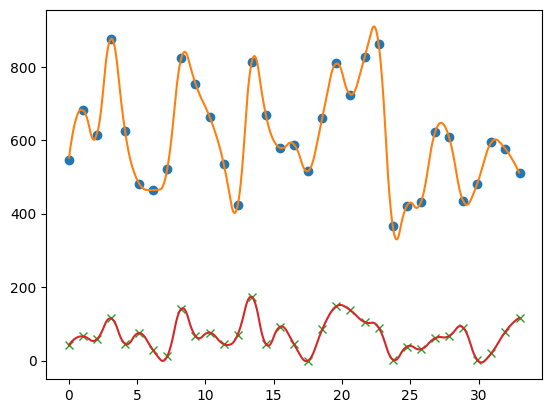

SHAPES:
X_train.shape, y_train.shape (1113, 7) (1113,)
X_test.shape, y_test.shape (100, 7) (100,)
None
None
X_train.shape (1113, 7)
y_train.shape (1113,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[614.02593911 585.08965315 618.78303534 619.55107279 642.77492755
 578.7146541  576.37802885 587.40306479 753.17691199 539.48206238
 660.2436219  704.7224349  584.4324906  808.13534871 405.58898139
 433.587519   667.03613799 559.06137159 655.47041726 697.97934526
 658.05757158 672.75230237 658.05765475 471.65762404 470.63136985
 482.02052431 562.82938955 729.80407834 682.22047434 539.4348378
 563.37236131 691.75149877 614.75057495]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1113, 7)
y_train.shape (1113,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[614.03028474 585.09041464 618.78625237 619.55161458 642.77029329
 578.71934216 576.37995437 587.40402396 753.1781283  539.48059247
 660.24863676 704.72440993 584.438679 

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[605.51928712 600.25793816 622.39071162 656.30842589 628.8278202
 600.47206331 566.40789189 552.95744562 774.69209816 562.62434772
 656.40780282 670.38450102 604.788769   833.8475853  437.12725669
 490.6980338  650.34939246 532.21852152 662.84950208 735.41118239
 690.90298639 688.68325227 661.38662576 472.52008278 491.30580914
 494.33809898 574.11736474 708.46631718 682.5606979  521.08030571
 546.07777323 684.33890306 644.10802518]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1113, 7)
y_train.shape (1113,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[604.84554649 676.15895165 606.14239495 844.91505317 443.85210869
 747.38643914 573.90160391 531.28739058 815.98345136 577.27207358
 680.68066678 607.61824521 473.41021213 789.59966982 703.10440693
 855.60876392 589.47570094 578.01874761 652.29768602 804.02284598
 804.34381064 756.59132925 837.83969181 333.06354407 424.00250741
 431.5581386  633.26947769 632.5102

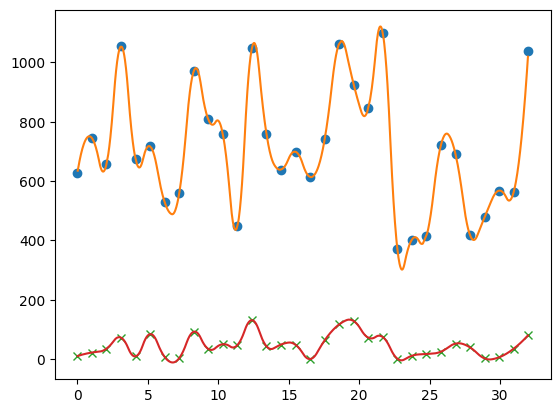

SHAPES:
X_train.shape, y_train.shape (1068, 7) (1068,)
X_test.shape, y_test.shape (100, 7) (100,)
None
None
X_train.shape (1068, 7)
y_train.shape (1068,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[ 793.66128546  662.67760215  705.01950003  667.37808483  594.18858864
  793.44496415  786.796522    641.45743702  831.37767706  711.00245856
  800.64631754  785.4822105   893.45931499  514.54040979  576.47749221
 1049.08100766  692.32229262  813.09212441  886.56055184  820.4163168
  829.7497761   795.69765968  883.52495531  494.35131668  551.58626237
  448.87472767  983.17315786  624.55394912  240.26119178  593.80247486
  737.29873501  413.43700056]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1068, 7)
y_train.shape (1068,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[ 793.63713141  662.66424316  705.00748934  667.38966685  594.18839781
  793.44764272  786.76854265  641.45609732  831.38083889  710.99136283
  800.640

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[ 608.2851685   602.89017187  654.50339796  771.06471636  614.77686509
  808.84966486  580.65486358  604.31256195  862.90323021  641.59875556
  731.46409126  665.96474354 1023.51562842  691.2388035   677.22677411
  728.28386861  531.65504151  763.45006956  951.60867841  998.65622906
  777.53016269  803.57035629  548.02331588  567.61896989  572.07964429
  635.83137914  730.94977315  660.40202567  556.07887353  560.36113965
  706.68878619  827.63202823]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1068, 7)
y_train.shape (1068,)
X_test.shape (100, 7)
y_test.shape (100,)
Estimation
[ 536.28508157  687.56500687  649.61928016  910.46071475  625.58356591
  772.51763027  606.51697747  576.53725603  971.17700689  734.09194145
  762.05411275  646.77235841 1001.13495755  784.28646664  711.57487617
  627.77240862  551.99318552  699.84021882 1008.8450797   987.26908234
  812.68787408  956.56920936  354.19593392  415.77050841  755

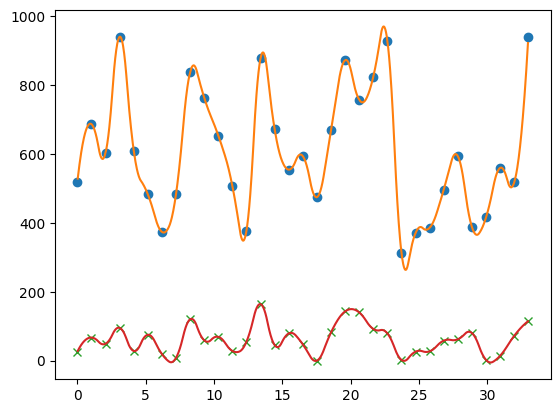

SHAPES:
X_train.shape, y_train.shape (1166, 11) (1166,)
X_test.shape, y_test.shape (100, 11) (100,)
None
None
X_train.shape (1166, 11)
y_train.shape (1166,)
X_test.shape (100, 11)
y_test.shape (100,)
Estimation
[ -5836.27272973   2792.79021835  -1207.87493533  10041.86295512
   3633.38996526   9717.74066865   2306.6282168   -1402.11215339
   1763.30888538   5730.98319814  -1874.86386194    751.01717636
  11382.3354816   -1932.91421802 -10349.53822717  10229.28527185
 -14344.89732752   4609.87636272  -3754.0877724     448.07266813
   4508.98227796    698.78480612  -1546.11943765  -4106.58827446
  10252.57918201   8968.51944664   -402.97744093 -17412.34665818
  11401.5319164   -5519.45499217   1032.99342189   3013.55974694
 -13369.98051353]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1166, 11)
y_train.shape (1166,)
X_test.shape (100, 11)
y_test.shape (100,)
Estimation
[ -4316.13293512   2269.94704616   -770.91003759   7815.929267

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[551.70407418 554.74554542 595.12779394 559.23037833 510.39533465
 504.93845677 455.95102915 507.64924323 703.26371081 522.93000723
 622.56932757 602.9669892  438.8315456  872.57642649 600.00612592
 509.32186382 644.92068247 404.97167897 693.56105147 760.60406334
 738.43945232 637.38119357 635.84959344 454.75387766 387.55453815
 403.53819656 552.11753998 691.94797872 503.8402624  531.33796661
 448.89919835 580.4505586  803.3285972 ]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1166, 11)
y_train.shape (1166,)
X_test.shape (100, 11)
y_test.shape (100,)
Estimation
[579.27700986 684.98971412 588.29114525 936.62523507 645.3992997
 920.73176633 373.97489171 493.76044918 843.14394171 584.49932018
 671.72895944 492.26887043 437.86497746 863.14996895 764.17547495
 937.48835164 596.47485775 482.55738654 659.63844661 867.86830614
 751.13851435 678.13138229 936.11097146 317.19661527 366.3311415
 362.92542986 612.07344883 593.961

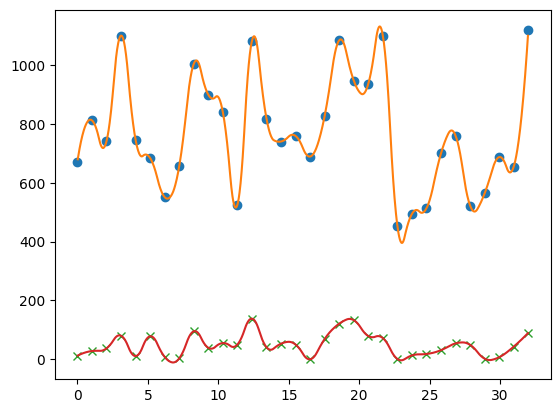

SHAPES:
X_train.shape, y_train.shape (1132, 11) (1132,)
X_test.shape, y_test.shape (100, 11) (100,)
None
None
X_train.shape (1132, 11)
y_train.shape (1132,)
X_test.shape (100, 11)
y_test.shape (100,)
Estimation
[-17582.65081494  14900.38003133   1229.22324808  34311.94165059
   3867.88099041  40626.10122855  -2843.11836625 -13576.21100836
   4148.9466782   32116.77115831  -9887.73860401  53313.21786901
  -6543.09289599 -32683.30328261  46987.71965002 -60719.37111697
  22265.98584598  -5075.92216235  -6166.21234472  11748.1569606
   3247.1660169  -13590.29778385 -25049.05357232  44309.37290283
  36775.67529449   5410.98894052 -83653.37247847  45290.62558832
 -45702.31398979    195.86255248  -4675.60154077 -48227.71598877]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1132, 11)
y_train.shape (1132,)
X_test.shape (100, 11)
y_test.shape (100,)
Estimation
[-12964.09177955  11259.08757606   1084.98969446  25798.28258863
   3109.9069247

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[ 729.81126203  636.80543536  703.20258586  722.81224087  704.89487342
  711.5598675   714.33098467  759.52574956  828.53747831  656.63440011
  843.82843884  604.90370179 1025.19617806  742.36500369  636.14882882
  815.9891321   641.31879027  884.77758271  971.16384113  938.75126264
  817.04730401  849.85422618  663.51939193  557.94756716  558.78664682
  704.09063597  837.73209357  634.68307216  683.77040792  629.52545121
  781.03226676  798.65454165]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1132, 11)
y_train.shape (1132,)
X_test.shape (100, 11)
y_test.shape (100,)
Estimation
[ 770.63802356  808.30717409  740.71252718 1095.46438242  774.8911082
  649.58085589  553.5085604   675.00929753 1004.35133253  913.81562897
  872.74455578  566.4650567  1071.2076175   826.28973453  634.82113353
  759.66187079  691.46448157  830.98342511 1076.7720922   918.64301001
  914.94524674 1090.64951979  476.92279198  490.98800037  50

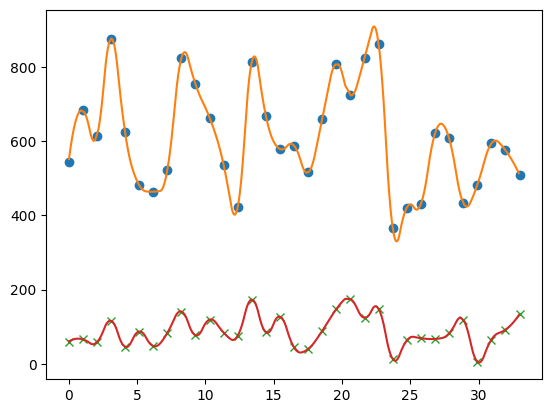

SHAPES:
X_train.shape, y_train.shape (1073, 4) (1073,)
X_test.shape, y_test.shape (100, 4) (100,)
None
None
X_train.shape (1073, 4)
y_train.shape (1073,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[546.60757848 556.34680831 538.88619497 664.29878178 526.99194377
 597.80038415 522.5088539  613.65337385 726.25126362 581.85891713
 680.45753458 614.07066062 570.98065318 803.67792546 604.98589312
 687.9802196  514.04007166 508.70958257 615.98274484 740.24347185
 802.07160432 685.76943638 741.98696805 440.16898974 545.68006854
 559.16781519 570.45054023 604.43143129 683.85735216 438.81712894
 564.3854781  629.09037929 722.02263409]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1073, 4)
y_train.shape (1073,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[546.60810163 556.34730028 538.88681894 664.29847251 526.99247683
 597.80061813 522.50953278 613.65317704 726.25039253 581.8591972
 680.45698157 614.07048299 570.9811254

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[565.95672827 572.3575131  558.64642775 656.69039019 554.61836559
 603.28165522 547.81037818 624.86437824 708.08413835 592.94983022
 672.95019894 624.5361544  581.17666439 771.70198724 613.21583496
 675.16496412 541.25737025 538.33477921 622.69334539 718.59387555
 768.22188198 675.04034157 720.61077382 480.94171441 562.45093392
 573.18805004 587.86194073 615.00726578 676.88315058 485.05448971
 582.46769357 635.42358216 708.86903149]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1073, 4)
y_train.shape (1073,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[547.57730108 665.03481599 653.00067362 723.35895159 446.61869567
 417.00699623 541.76036499 538.65115637 851.24949138 660.33526129
 736.6650438  569.7295136  418.1014622  770.78689711 686.50070991
 724.29439002 568.53567058 576.9947166  658.29037908 907.13597688
 906.24397737 822.07095044 906.24397737 334.69727511 427.05916726
 427.05916726 521.95256552 515.467

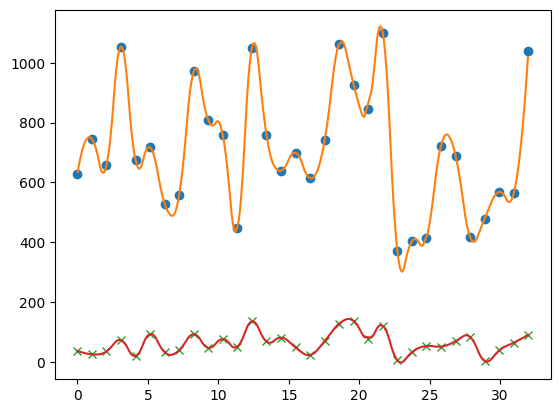

SHAPES:
X_train.shape, y_train.shape (1038, 4) (1038,)
X_test.shape, y_test.shape (100, 4) (100,)
None
None
X_train.shape (1038, 4)
y_train.shape (1038,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[644.13316772 556.71055841 597.72398039 720.68062119 588.79699323
 794.43511039 611.09488164 670.21554822 811.78545656 635.02028937
 770.8719058  630.15158267 988.71547925 728.31219484 746.4820289
 668.98032937 557.27010918 731.09130786 944.79058089 980.64047212
 741.26975994 922.95237203 500.33890752 587.41316495 651.49761983
 673.37071563 737.80112759 770.98562828 496.55681024 619.4809589
 751.53423198 812.36125341]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1038, 4)
y_train.shape (1038,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[644.13361465 556.71306305 597.7257853  720.68075501 588.79817107
 794.43416924 611.09607795 670.2152852  811.78390151 635.0216346
 770.87068263 630.15332623 988.7108971  728.31184225 

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[621.70489805 563.39123407 602.28783464 737.43487067 559.96286451
 815.34869001 598.43946605 634.93039349 817.99323809 645.33297178
 763.28473844 654.41150495 985.42294624 729.19790985 769.05748811
 658.3176244  558.28090054 732.68481742 953.56066671 985.60367675
 754.26789188 925.78563071 493.41263328 591.22598881 666.19430493
 667.57610092 734.72863598 781.80208506 486.97982892 616.83619448
 725.70982154 815.52823979]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1038, 4)
y_train.shape (1038,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[684.49086472 686.86333325 649.61928016 778.32324928 643.62489467
 787.20399643 659.12298239 585.43833009 802.55353567 768.09501551
 827.71672502 900.97859847 932.03979163 657.83526216 823.57951355
 667.77562665 430.60718012 657.83526216 991.50562251 949.09332198
 794.78362901 931.8272621  547.65226973 638.80783026 811.08754607
 755.96353756 767.17808216 634.71783326 539.619

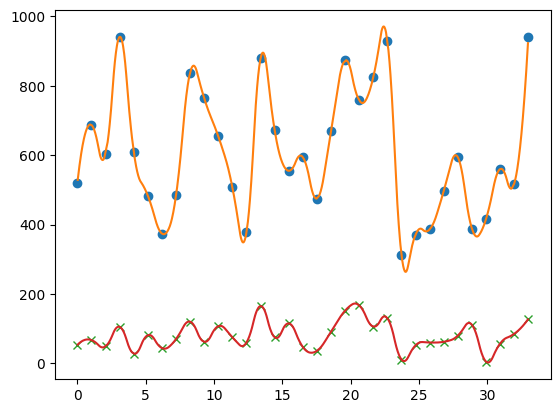

SHAPES:
X_train.shape, y_train.shape (1092, 5) (1092,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (1092, 5)
y_train.shape (1092,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[537.07687707 570.42704832 524.75897571 668.07672678 473.77055055
 605.41817295 513.71963824 584.14242323 707.71098884 557.81810327
 675.53179281 594.92015944 550.88623976 825.30576872 593.68349892
 693.29461688 523.03535554 494.38720659 635.05950259 789.79710206
 829.05085319 671.67345916 733.7612466  428.7264687  530.98304172
 551.31431456 559.62553018 605.65033178 682.07068444 414.89898457
 545.06646662 618.21171297 728.39899068]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1092, 5)
y_train.shape (1092,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[537.077668   570.42635186 524.75879853 668.07555302 473.77212341
 605.41680866 513.7204275  584.14468881 707.71017023 557.81758932
 675.53175043 594.92132793 550.884855

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[536.87276254 547.94416173 515.42268615 624.72561063 492.50095482
 569.77382378 517.18185398 593.3830666  662.16932486 539.41281726
 643.94811731 589.90881339 523.62048135 765.92504064 581.80113703
 641.78829956 533.77614105 509.05115943 615.83704738 725.87547367
 760.82451825 633.47932128 684.68910365 449.24358326 511.74778232
 526.4269847  551.26249809 586.12272647 627.51039841 447.55021345
 529.94597168 594.34223723 679.18728003]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1092, 5)
y_train.shape (1092,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[434.46330372 682.01565073 575.88280889 831.10622082 403.45783229
 467.3775089  433.30816337 505.80139284 895.00821678 683.13734741
 654.59639634 607.72665371 380.95589111 755.88491412 613.3787244
 702.76539229 505.23769547 403.45783229 679.19554037 963.48119015
 967.16918615 756.74615992 903.98979946 457.48470705 455.09411676
 380.25823198 482.79268021 556.7231

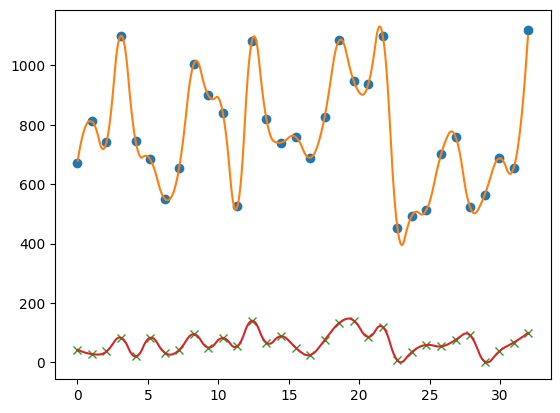

SHAPES:
X_train.shape, y_train.shape (1065, 5) (1065,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (1065, 5)
y_train.shape (1065,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[ 720.59499136  646.41414927  691.09188684  789.69999436  679.75255326
  783.21275569  685.6198612   781.34934656  846.44977256  711.34394139
  850.45434956  693.29272072 1004.40196601  787.668438    798.72594378
  740.39548848  669.88089439  819.65375209  961.75510662  993.57114318
  820.10553558  926.38492021  601.11535068  663.95821555  721.32905477
  742.200814    798.10488276  815.59289996  613.97682563  687.98929443
  798.55576202  870.14252246]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1065, 5)
y_train.shape (1065,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[ 720.5958133   646.41535494  691.09286316  789.69911273  679.75434889
  783.21183978  685.62101548  781.35054132  846.44857024  711.3443524
  850.453

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[ 702.03018324  574.19298421  651.31359018  724.79921851  686.20169676
  708.76490062  652.59212236  855.89583868  820.65525058  653.25837284
  878.66487394  590.13722702 1044.52081306  782.69308554  728.60392127
  725.06423121  643.29773437  828.44219999  965.01808036 1014.04969095
  788.84902125  929.40714826  539.94805311  591.64987813  644.63023533
  714.7228237   771.47959614  759.19079972  586.54096193  643.64500337
  805.90207113  860.71145466]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1065, 5)
y_train.shape (1065,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[ 621.39294333  803.8168566   653.12547557  633.92223014  723.49039683
  609.89253953  594.52514842  659.6403431   955.65368801  759.73919854
  762.98806752  644.75041227  955.94414269  824.92698759  609.89253953
  656.01554128  566.63445528  761.6397296  1025.04685867 1042.46445267
  904.74715032 1036.36192216  675.53349015  829.09926248  769

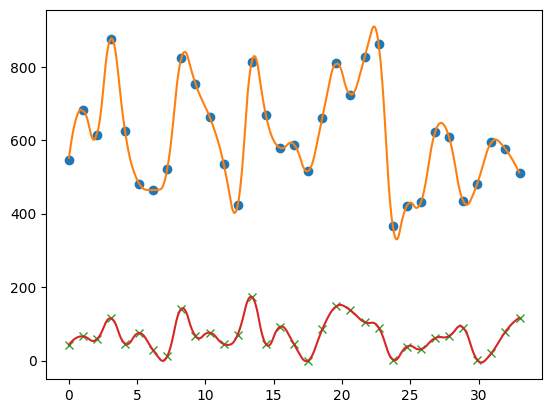

SHAPES:
X_train.shape, y_train.shape (1083, 4) (1083,)
X_test.shape, y_test.shape (100, 4) (100,)
None
None
X_train.shape (1083, 4)
y_train.shape (1083,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[555.74302482 584.14498857 578.73197653 672.57086916 606.23707682
 582.12654188 528.28698027 534.71216603 771.72109802 576.67898038
 634.01202305 622.40389287 570.1151959  862.18796832 515.69932256
 578.4966442  583.46106838 482.13676274 660.66787847 766.37059994
 737.09072173 675.95163407 648.53550667 444.84131813 490.06059217
 478.88310435 603.8183293  656.42926006 676.73525714 502.22856457
 519.4120931  676.44240441 725.24262337]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1083, 4)
y_train.shape (1083,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[555.74302751 584.14540638 578.73207409 672.57126416 606.23627803
 582.1273054  528.28715716 534.71175803 771.7201366  576.67976867
 634.01167057 622.40256192 570.115986

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[562.92958465 600.38550535 590.10893117 696.0230779  600.26805721
 605.55619638 534.77259054 527.94443996 780.4333987  597.05247719
 640.69123148 609.53383094 594.14981676 864.96703709 542.32263455
 618.75081568 582.32321705 483.23219506 665.61458056 783.00789496
 755.93789634 690.09222395 660.8778576  461.2800844  517.75288861
 504.77126932 611.19292152 648.13925791 679.85276392 498.99945919
 523.36082765 671.55280977 734.47725307]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1083, 4)
y_train.shape (1083,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[532.39329349 677.61658326 606.37210175 866.24662453 592.8275549
 595.62589977 455.99126355 511.14470013 785.1795787  578.81561956
 669.85126281 547.66497074 433.76416604 812.9329234  673.58844899
 585.94137766 587.35864723 523.40685318 578.42403414 805.14959623
 730.01804705 709.36695071 765.47872987 361.85137082 408.24930293
 431.09925336 616.36070341 594.0870

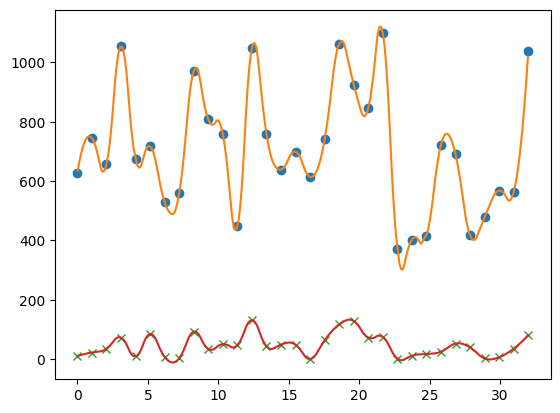

SHAPES:
X_train.shape, y_train.shape (1029, 4) (1029,)
X_test.shape, y_test.shape (100, 4) (100,)
None
None
X_train.shape (1029, 4)
y_train.shape (1029,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[ 581.39310985  577.08348511  642.45864438  794.03434086  609.59043328
  831.21447185  542.52121635  591.74977077  905.14234869  621.70356991
  737.29887189  643.85670164 1113.70608362  704.35147687  672.80726513
  717.26999775  481.20802315  777.16122499 1015.04209947 1083.60094135
  790.55155992  826.51645792  492.29407356  543.26198099  539.22709755
  639.11354477  721.55903235  649.7710538   554.98378291  526.96790675
  715.84847233  891.96816086]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1029, 4)
y_train.shape (1029,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[ 581.39311356  577.084948    642.4593783   794.03431608  609.59086549
  831.21373861  542.52184115  591.74984947  905.1405234   621.70453178
  737.29

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[ 569.69280987  597.74661217  654.13139006  803.84417414  594.39185507
  838.19706114  544.08225365  569.72088681  890.72279113  640.01284638
  724.91363825  672.19260713 1068.90032221  709.59773778  699.99117985
  699.66662528  503.82130402  770.5362686   990.86836185 1050.94056418
  793.27799135  814.7024666   503.01595686  567.19713719  571.87136435
  645.56564978  711.37394547  666.2119935   571.73994061  543.48935459
  689.34144794  884.68427295]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1029, 4)
y_train.shape (1029,)
X_test.shape (100, 4)
y_test.shape (100,)
Estimation
[ 548.08602068  713.37448602  643.82605979  985.42095201  655.49973656
  706.85332308  643.1347975   540.57846582  969.71748811  598.71495664
  746.34454498  675.52472177 1036.74452402  809.0559458   641.21558828
  685.14395872  538.39010366  854.2601977  1048.88469585  921.30412962
  805.61956166  943.56491704  381.48695842  432.83827719  508

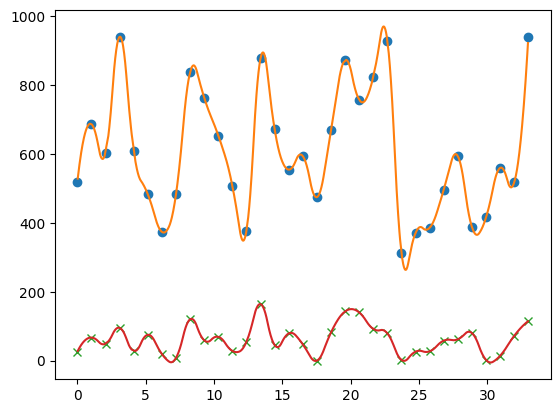

SHAPES:
X_train.shape, y_train.shape (1106, 5) (1106,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (1106, 5)
y_train.shape (1106,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[513.79670735 584.69140333 539.32254772 676.9678552  550.63450449
 583.76610533 484.23634637 540.78444062 791.88543069 565.01915973
 648.06455635 552.26253985 500.90577431 991.44668885 582.35113455
 609.82166674 622.33515139 451.82075337 712.76344446 863.77598672
 871.31987432 693.47782681 656.69298953 424.56896227 420.94475981
 416.77630544 610.4950469  611.39834165 586.31012645 467.8630186
 411.13091751 640.82549455 779.78307773]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1106, 5)
y_train.shape (1106,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[513.79691316 584.69168444 539.32276014 676.96736809 550.63508595
 583.76625201 484.23670299 540.78444402 791.88436392 565.01997218
 648.06380931 552.26196586 500.9062450

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[494.76591114 556.52625576 508.81861838 631.91559272 555.40957065
 543.59442472 465.72140009 541.43890992 747.06248631 554.25095649
 607.76115033 520.08628314 459.31811748 925.81194898 598.24507702
 602.33108462 570.06343135 437.98690704 673.59262885 806.01214864
 824.74475315 643.6684688  612.76782799 420.70665338 419.88291782
 407.01461834 607.43044471 545.3215304  550.31254338 464.00519069
 406.50241211 609.94923426 772.26299039]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1106, 5)
y_train.shape (1106,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[471.98677174 677.75903342 588.47730864 864.44546087 668.30189972
 568.9426289  526.97111734 478.38752699 835.45353665 584.33403642
 647.37163697 482.59520721 450.11734128 863.14996895 676.19757954
 832.75457744 540.20818941 476.96588084 653.36842256 868.55054797
 752.92453205 929.37748163 820.98647615 450.98029759 355.4742309
 366.3311415  486.7790722  544.7351

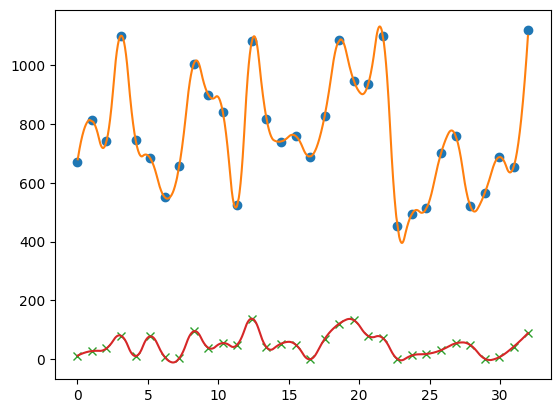

SHAPES:
X_train.shape, y_train.shape (1050, 5) (1050,)
X_test.shape, y_test.shape (100, 5) (100,)
None
None
X_train.shape (1050, 5)
y_train.shape (1050,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[ 640.87847771  661.2656186   726.96492086  836.47271752  732.31740811
  795.77732251  621.87038544  756.26836264  919.22591121  732.41950936
  836.78535226  659.15743977 1142.95950921  802.23843638  722.03692306
  754.28865291  598.39858887  874.73864959 1022.24161189 1103.67804637
  844.97345431  836.90775638  548.34911744  620.6031363   595.41890023
  752.34634205  735.17514812  705.74214414  666.81887663  613.02316983
  793.81560359  991.20453617]
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1050, 5)
y_train.shape (1050,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[ 640.87916592  661.26618682  726.96510989  836.4721805   732.3181138
  795.77678667  621.87124406  756.26893915  919.22475968  732.41994708
  836.784

F:\ruslan\projects\pkogo\env_ogo\lib\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


Estimation
[ 659.94035792  660.84496442  730.46106313  806.65774893  753.42027533
  768.49874731  639.2460542   796.15857237  894.77962892  721.56687562
  844.40542346  643.01582709 1109.07787728  799.56159036  699.47306852
  765.70858169  623.31466988  873.16457851  989.2417332  1065.19832433
  829.22409437  825.55636101  572.59682731  619.46055803  590.6807058
  748.28776198  737.05720084  690.76286889  686.09979191  624.51283626
  799.70087108  956.52615466]
ERROR1 START
'QuantileRegressor' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (1050, 5)
y_train.shape (1050,)
X_test.shape (100, 5)
y_test.shape (100,)
Estimation
[ 691.99933048  807.17641506  729.44359939 1081.18573243  773.61311726
  679.03411623  678.32540028  646.80191898 1031.38497329  721.07471089
  858.19523857  628.0008552  1076.77259928  837.55466514  842.34431825
  756.21530269  698.93647728  828.13671666 1083.34894718  929.43359299
  852.41426023 1036.47034617  431.09079506  520.55509731  606.

In [30]:
experiments = [
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=1000, aug_mpl=40, aug_pow=2, aug_mirror=False, grid_search=False, scaler_x=None, scaler_y=None, shuffle=True, verify=True),
    compare_models(2024, pr_group=1, n_test=100, norms=True, aug_n=1000, aug_mpl=40, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x=None, scaler_y=None, shuffle=True, verify=True),
    compare_models(2024, pr_group=2, n_test=100, norms=True, aug_n=1000, aug_mpl=40, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x=None, scaler_y=None, shuffle=True, verify=True),
]

#### Код записи результатов экспериментов в файл experiment.csv

In [31]:
exp_results = []
for ds in experiments:
    #print(ds)
    for k, v in ds.items():
        exp_results.extend(v)
        
exp_results.sort(
    key=lambda row: (row['Dataset_name'], -row['R2'])
)
write_experiment_csv(2024, exp_results, exp_fieldnames, 'experiment')